# GenFL - Building a learnt Prior

This notebook shows an example of how to reproduce the first step to get some results from the paper `Federated Learning with Nonvacuous Generalisation Bounds`.
Specifically the ones from Table 1.

Abstract

We introduce a novel strategy to train randomised predictors in federated learning, where each node of the network aims at preserving its privacy by releasing a local predictor but keeping secret its training dataset with respect to the other nodes. We then build a global randomised predictor which inherits the properties of the local private predictors in the sense of a PAC-Bayesian generalisation bound. We consider the synchronous case where all nodes share the same training objective (derived from a generalisation bound), and the asynchronous case where each node may have its own personalised training objective. We show through a series of numerical experiments that our approach achieves a comparable predictive performance to that of the batch approach where all datasets are shared across nodes. More over the predictors are supported by numerically nonvacuous generalisation bounds while preserving privacy for each node. We explicitly compute the increment on predictive performance and generalisation bounds between batch and federated settings, highlighting the price to pay to preserve privacy

This notebook has 2 main parts:
1. Perez FL Scenario 
2. Dziugaite FL Scenario

These parts are computably independant however explanation are not independant.

# Startup

The code is meant to be used as a bash CLI. For pedagogic reasons, let's see it through a notebook file.

In [ ]:
%cd ..

## 1. Perez FL Scenario

Now let's run the code. We will produce a prior with a config file in `./conf/scenario/perez_prior.yaml` using the default configuration `./conf/genfl_prior.yaml`.
Hydra as been configured to seek configuration files in the `./conf` folder.
The next command will then seek in `./conf/scenario` for the `perez_prior.yaml` file and combine the default configuration and this last configuration. If two parameters are the same in these two configuration files, the last one (`perez_prior`) has priority.

You can see in the configuration file, that the neural network is a `NNet4lPerez` than you can find `./core/model.py`. It's not a stochastic neural network (SNN), but we will use it for the next notebook to build a posterior (SNN).

In [ ]:
%%bash

python GenFL_prior.py +scenario=perez_prior

As you can see a directory has been created at `./outputs/GenFL_Prior/[Date]/[Time]/+scenario=perez_prior`.
In this folder, the files are like this:

```bash
(main) me@machine:./outputs/GenFL_Prior/[Date]/[Time]$ tree
.
└── +scenario=perez_prior
    ├── checkpoint_round_*.pth
    ├── GenFL_prior.log
    ├── histexact_iid_C=100_B=25_E=5_R=100_P=learnt.npy
    └── metrics
        ├── accuracy_Metrics_tmp.png
        ├── count_Metrics_tmp.png
        ├── hist_tmp.npy
        ├── Losses_metrics_tmp.png
        ├── loss_Metrics_tmp.png
        └── num_examples_Metrics_tmp.png
```

- `checkpoint_round_*.pth` are the model's checkpoints after the server's aggregation
- `GenFL_prior.log` is the log file
- Directory `/metrics` contains graphics `*.png` and an history `hist_tmp.npy`:
    - In each graphic, there are metrics (i.e. accuracy, loss) in at most 3 different plots: `centralized`, `distributed` and `distributed_fit`. It corresponds to 3 different kind of evaluation:
        - `centralized` is on the global test set, and made by the server (`get_evaluate_fn` from `./core/strategy.py`).
        - `distributed` is the aggregated metric from the clients, evaluated the aggregated model (the one in `checkpoint_round_{round}.pth`) (mostly on their train/prior set, no point to evaluate on a local test set for this i.i.d. setting). (metrics from `evaluate` method in `./core/client.py`)
        - `distributed_fit` is the aggregated metric from the client, made during the local training session of each clients. (metrics from `fit` method in `./core/client.py`)
    - `hist_tmp.npy` contains all the above metrics, in a serialized `.npy` object, at every round.
- `hist[something].npy` is the final `hist_tmp.npy` but contains some more information in the [something] name:
    - `exact` is the partition type (exactly iid, you can find it in `/core/partition.py`)
    - `C=100` means there are 100 Clients
    - `B=25` means client's training Batch size is 25
    - `R=100` means there have been 100 training Rounds
    - `P=learnt` is the type of the Prior (random or learnt)

# Example: `accuracy_Metrics_tmp.png`

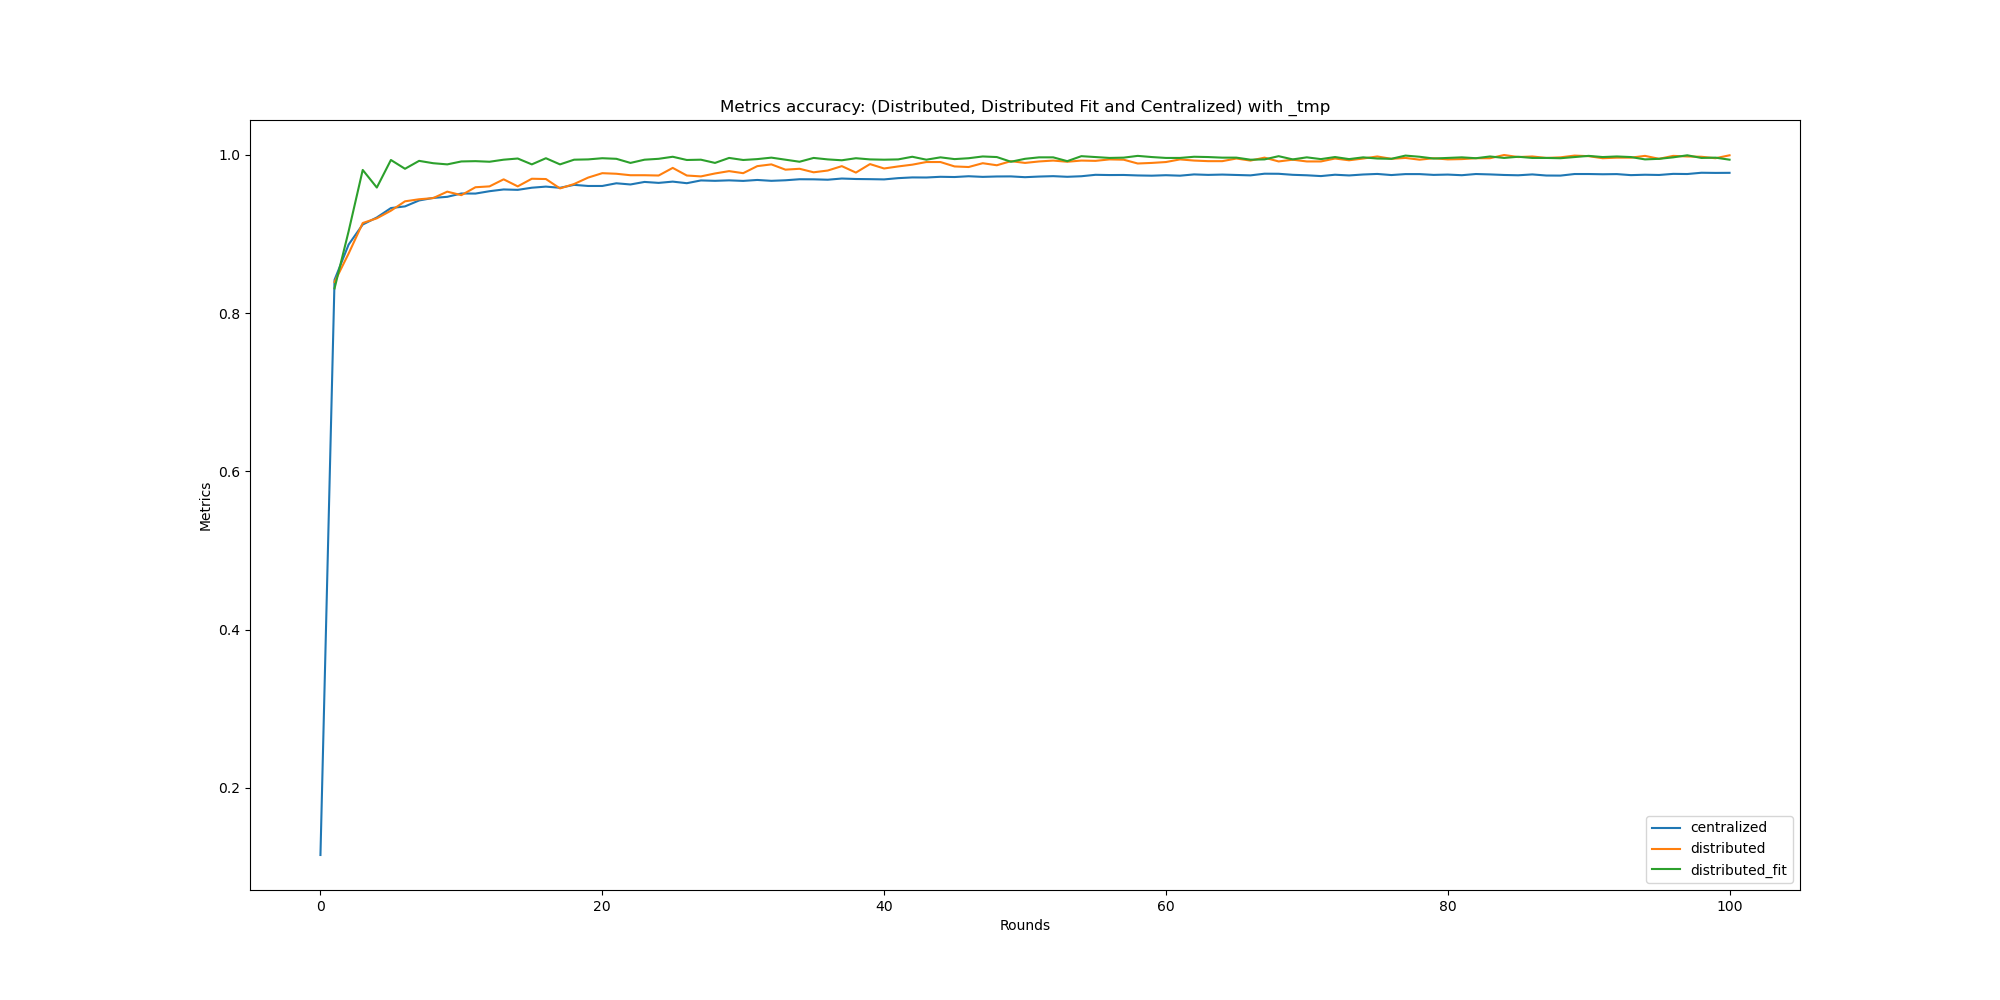

We can see the 3 plots. If you check in the code `centralized` is made on the test set of MNIST, `distributed` and `distributed_fit` are made on the training set of each client. As we can see the `distributed` plot is slowly reaching the same accuracy as `distributed_fit`. This is due to the fact that `distributed` is -global average model- evaluated on the training set of each clients whereas `distributed_fit` is -local model- whose metrics are averaged on the training set of each clients.

Let's jump into the next notebook `2. GenFL FL-SOB Posterior From Learnt Prior.ipynb` to see how to make a posterior from this prior.

## Dziugaite Scenario

Exactly as done before, we will use `dziugaite_prior.yaml` from `./conf/scenario` to learn a prior as in "Computing nonvacuous ..." from Dziugaite et al. Remember that it is not stricly a prior in the sense of PAC-Bayes, but rather a starting point for our posterior. To be precise, the prior is still a random initialization (see $\mathcal{N}(w_0, \lambda Id)$ in the paper)

In [ ]:
%%bash

python GenFL_prior.py +scenario=dziugaite_prior

The difference with the previous run is the PyTorch model `NNet4lDziugaite` that you can find in `./core/model.py` and the Labels. The 10 classes are transform to 2 classes to make a Binary task. ({5,6,7,8,9} become label 1 and others become label -1). Hence the loss function is changed (see `loss_logistic` in `./core/loss.py`)

As before, you can check that a directory has been created at `./outputs/GenFL_Prior/[Date]/[Time]/+scenario=dziugaite_prior`.
In this folder, the files are like before.

# Example: `accuracy_Metrics_tmp.png`

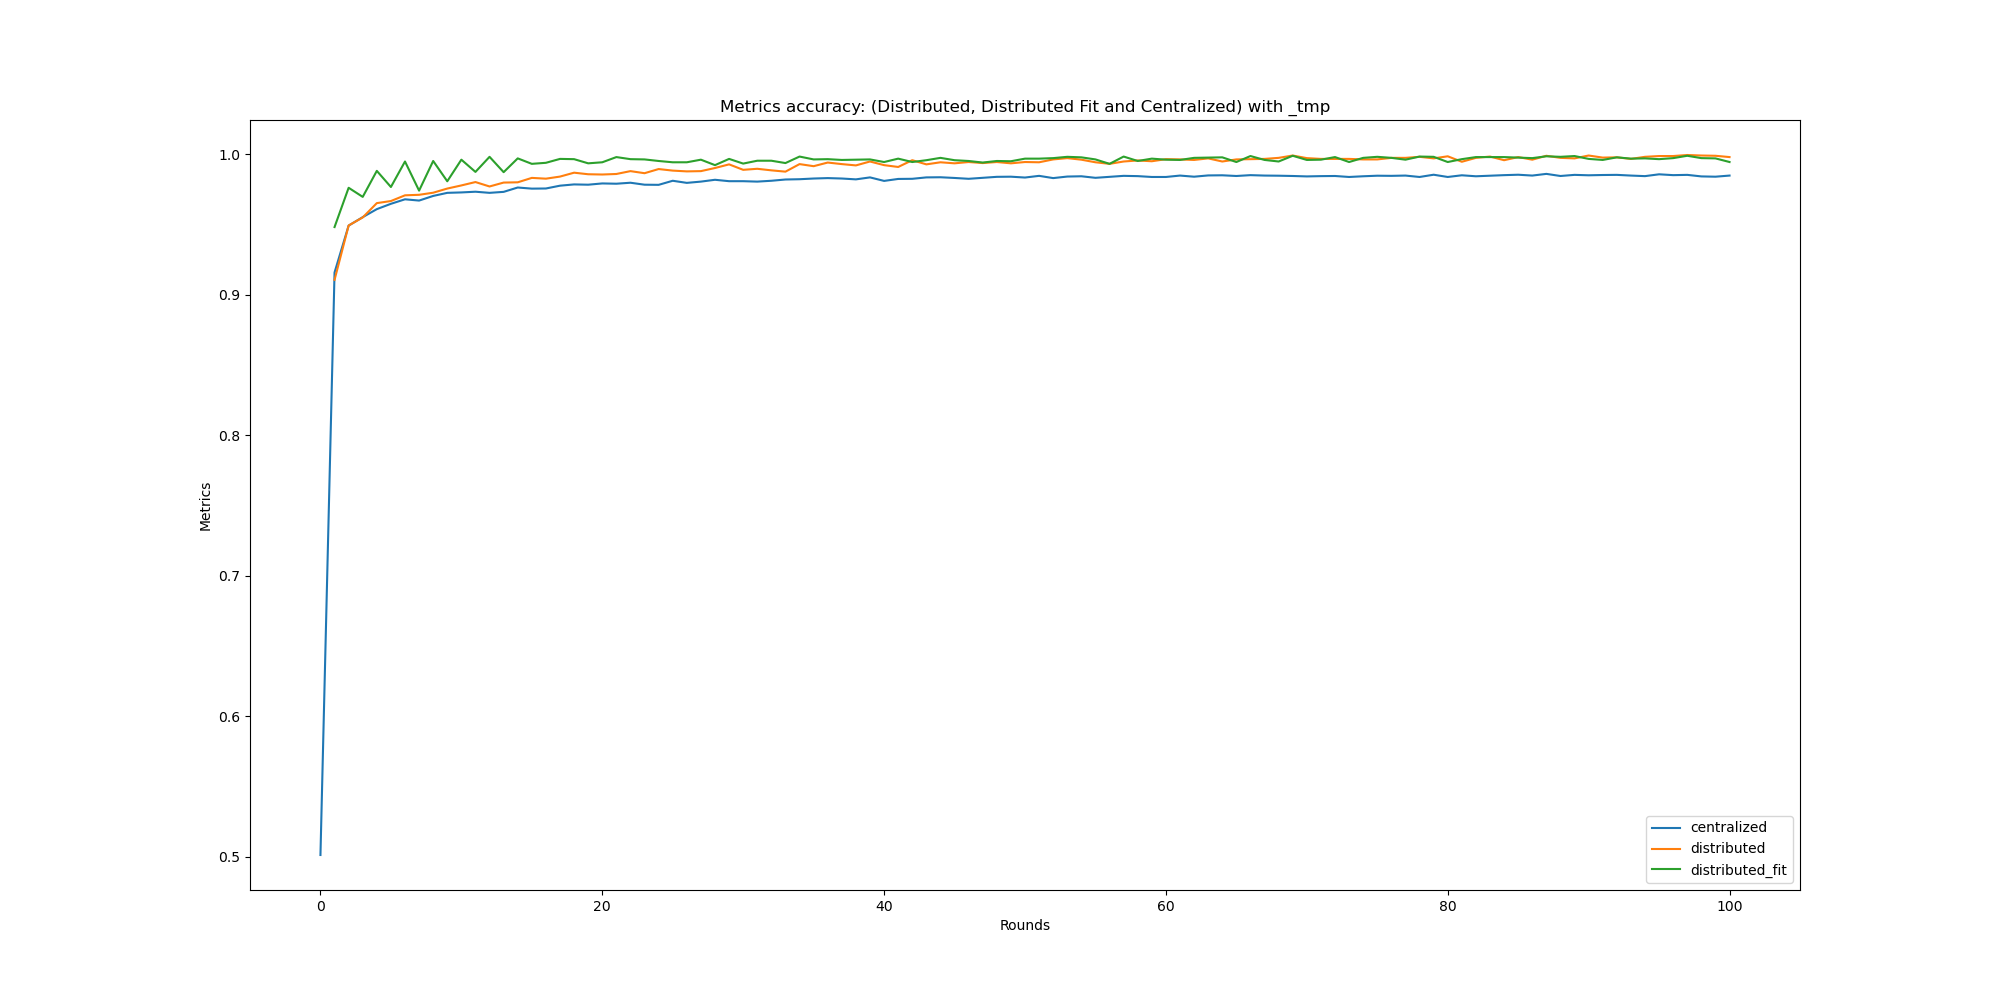

The accuracy is higher than previous figure (mainly because there is only 2 classes).

Let's jump into the next notebook `2. GenFL FL-SOB Posterior From Learnt Prior.ipynb` to see how to make a posterior from this "prior".